
# Gender Recognition by Voice and Speech Analysis



## 1. Wprowadzenie

Celem projektu jest identyfikacja głosu jako mężczyzny lub kobiety, w oparciu o właściwości akustyczne głosu i mowy.
Zbiór danych który zostanie użyty w projekcie składa się z 3168 zarejestrowanych próbek głosu, zebranych od mówców płci męskiej i żeńskiej.
Próbki głosu są wstępnie przetwarzane przez analizę akustyczną w R przy użyciu pakietów seewave i tuneR, z analizowanym zakresem częstotliwości od 0 do 280 Hz (ludzki zakres wokalny).



## 2. Jedziemy w temacie


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from scipy.cluster.hierarchy import linkage, dendrogram, ward, fcluster
from sklearn.cluster import AgglomerativeClustering
pd.set_option('display.max_rows', 21)

In [3]:
dane= pd.read_csv('voice.csv')
atrybuty=len(dane.columns)
obiekty=len(dane)
nf=pd.isnull(dane)
suma_kolumny=nf.sum(axis=0)
liczba_brakow=0
for k in suma_kolumny:
    liczba_brakow+=k
print(dane.groupby(['label']).count().shape[0])
print(obiekty)
print(atrybuty)

2
3168
21


In [4]:
def opisz_klasy(ramka_wej):
    df = ramka_wej.copy()
    d = df.describe()
    d.loc['label',:] = 'całość'
    # indeks -1 -> ostatni atrybut, zakładamy, że zawiera informację o klasie
    for k in list(df.iloc[:,-1].unique()): 
        desc = df[df.iloc[:,-1] == k].describe()
        desc.loc['label',:] = k
        d = pd.concat([d, desc], axis=1, sort=False)
    return d


In [5]:
print(opisz_klasy(dane))


        meanfreq         sd     median          Q25        Q75        IQR  \
count       3168       3168       3168         3168       3168       3168   
mean    0.180907   0.057126   0.185621     0.140456   0.224765  0.0843094   
std    0.0299178  0.0166522  0.0363601    0.0486797  0.0236393  0.0427831   
min    0.0393633  0.0183632  0.0109746  0.000228758  0.0429463  0.0145577   
25%     0.163662  0.0419535   0.169593     0.111087   0.208747  0.0425597   
50%     0.184838  0.0591551   0.190032     0.140286   0.225684    0.09428   
75%     0.199146  0.0670204   0.210618     0.175939    0.24366   0.114175   
max     0.251124   0.115273   0.261224     0.247347   0.273469   0.252225   
label     całość     całość     całość       całość     całość     całość   

           skew     kurt     sp.ent        sfm  ...       mode   centroid  \
count      3168     3168       3168       3168  ...       1584       1584   
mean    3.14017  36.5685   0.895127   0.408216  ...   0.178541      0.191  

In [6]:
dane= pd.read_csv('voice.csv')

dane.head()

meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3  0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4  0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...  0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...  0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   modindx  label  
0  0.275862  0.007812  0.007812  0.007812  0.000000  0.000000   male  
1  0.250000  0.009014  0.007812  0.054688  0.046875  0.052632   male  
2  0.271186  0.007990  0.007812  0.015625  0.007812  0.046512   male  
3  0.250000  0.201497  0.007812  0.562500  0.554688  0.247119   male  
4  0.266667  0.712812  0.007812  5.484375  5.476562  0.208274   male  

[5 rows x 21 columns]

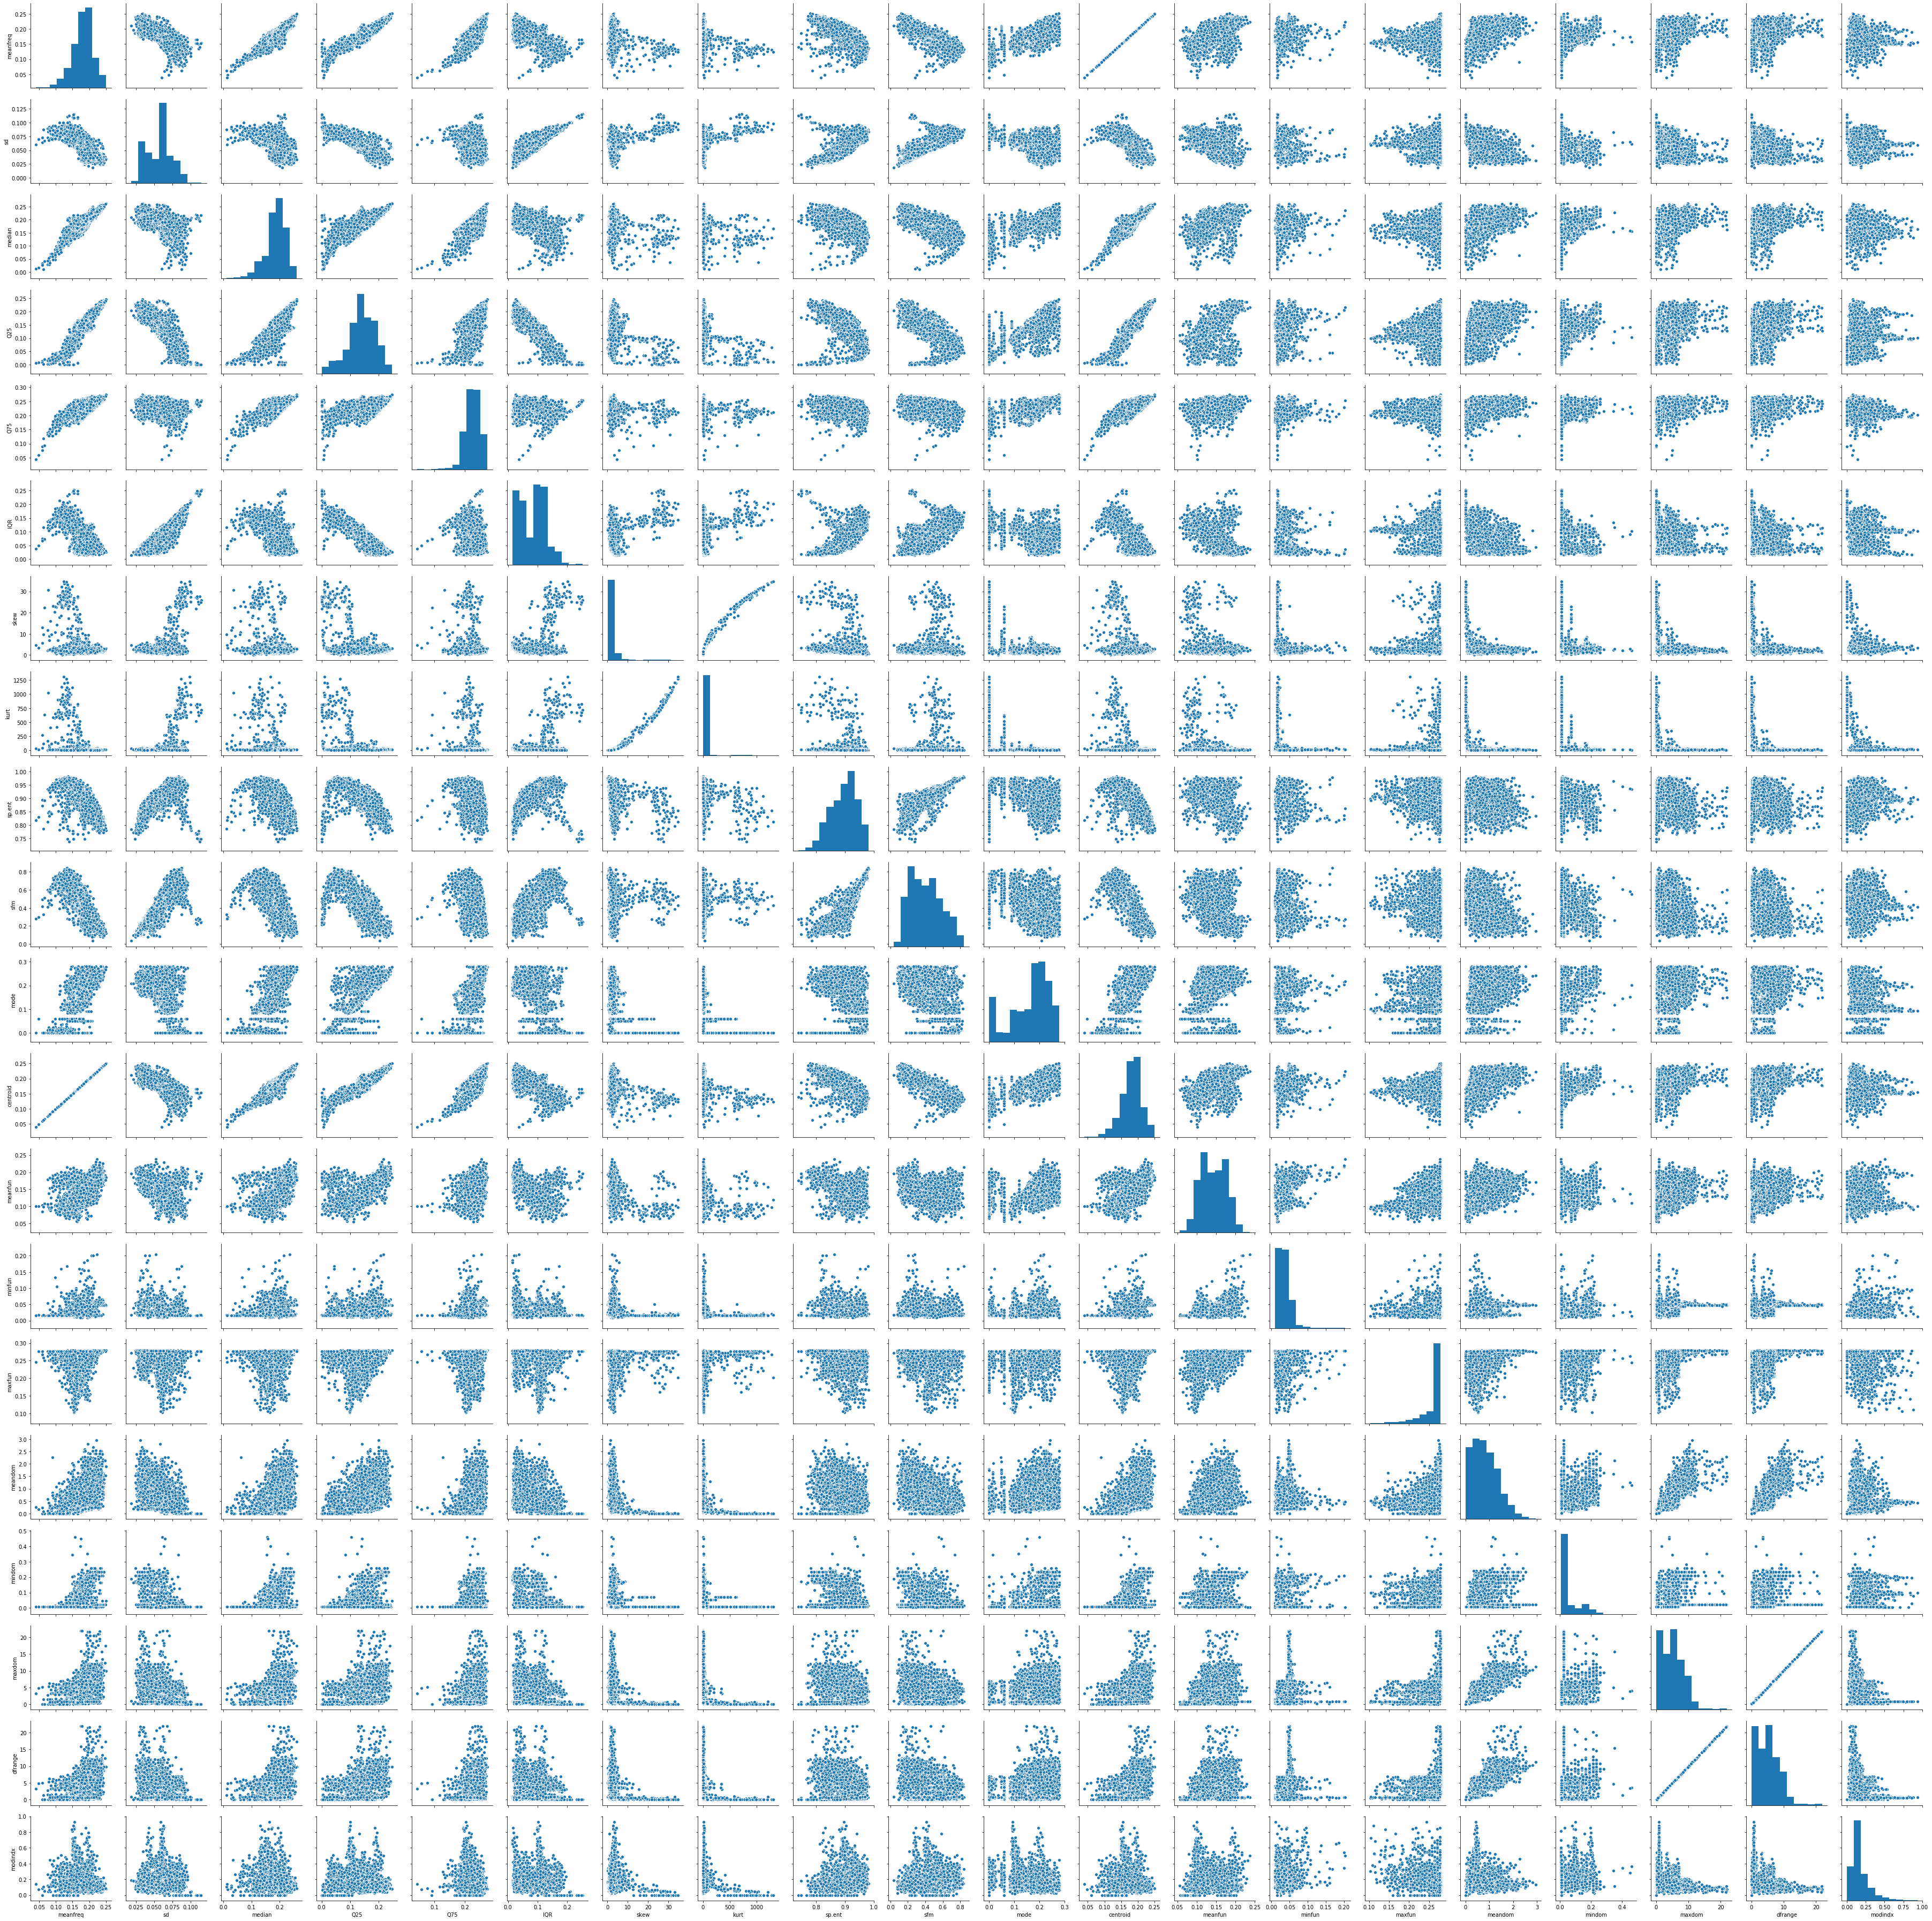

meanfreq        sd    median       Q25       Q75       IQR  \
meanfreq  1.000000 -0.739039  0.925445  0.911416  0.740997 -0.627605   
sd       -0.739039  1.000000 -0.562603 -0.846931 -0.161076  0.874660   
median    0.925445 -0.562603  1.000000  0.774922  0.731849 -0.477352   
Q25       0.911416 -0.846931  0.774922  1.000000  0.477140 -0.874189   
Q75       0.740997 -0.161076  0.731849  0.477140  1.000000  0.009636   
IQR      -0.627605  0.874660 -0.477352 -0.874189  0.009636  1.000000   
skew     -0.322327  0.314597 -0.257407 -0.319475 -0.206339  0.249497   
kurt     -0.316036  0.346241 -0.243382 -0.350182 -0.148881  0.316185   
sp.ent   -0.601203  0.716620 -0.502005 -0.648126 -0.174905  0.640813   
sfm      -0.784332  0.838086 -0.661690 -0.766875 -0.378198  0.663601   
mode      0.687715 -0.529150  0.677433  0.591277  0.486857 -0.403764   
centroid  1.000000 -0.739039  0.925445  0.911416  0.740997 -0.627605   
meanfun   0.460844 -0.466281  0.414909  0.545035  0.155091 -0.534462   
minfun    0.383937 -0.345609  0.337602  0.320994  0.258002 -0.222680   
maxfun    0.274004 -0.129662  0.251328  0.199841  0.285584 -0.069588   
meandom   0.536666 -0.482726  0.455943  0.467403  0.359181 -0.333362   
mindom    0.229261 -0.357667  0.191169  0.302255 -0.023750 -0.357037   
maxdom    0.519528 -0.482278  0.438919  0.459683  0.335114 -0.337877   
dfrange   0.515570 -0.475999  0.435621  0.454394  0.335648 -0.331563   
modindx  -0.216979  0.122660 -0.213298 -0.141377 -0.216475  0.041252   

              skew      kurt    sp.ent       sfm      mode  centroid  \
meanfreq -0.322327 -0.316036 -0.601203 -0.784332  0.687715  1.000000   
sd        0.314597  0.346241  0.716620  0.838086 -0.529150 -0.739039   
median   -0.257407 -0.243382 -0.502005 -0.661690  0.677433  0.925445   
Q25      -0.319475 -0.350182 -0.648126 -0.766875  0.591277  0.911416   
Q75      -0.206339 -0.148881 -0.174905 -0.378198  0.486857  0.740997   
IQR       0.249497  0.316185  0.640813  0.663601 -0.403764 -0.627605   
skew      1.000000  0.977020 -0.195459  0.079694 -0.434859 -0.322327   
kurt      0.977020  1.000000 -0.127644  0.109884 -0.406722 -0.316036   
sp.ent   -0.195459 -0.127644  1.000000  0.866411 -0.325298 -0.601203   
sfm       0.079694  0.109884  0.866411  1.000000 -0.485913 -0.784332   
mode     -0.434859 -0.406722 -0.325298 -0.485913  1.000000  0.687715   
centroid -0.322327 -0.316036 -0.601203 -0.784332  0.687715  1.000000   
meanfun  -0.167668 -0.194560 -0.513194 -0.421066  0.324771  0.460844   
minfun   -0.216954 -0.203201 -0.305826 -0.362100  0.385467  0.383937   
maxfun   -0.080861 -0.045667 -0.120738 -0.192369  0.172329  0.274004   
meandom  -0.336848 -0.303234 -0.293562 -0.428442  0.491479  0.536666   
mindom   -0.061608 -0.103313 -0.294869 -0.289593  0.198150  0.229261   
maxdom   -0.305651 -0.274500 -0.324253 -0.436649  0.477187  0.519528   
dfrange  -0.304640 -0.272729 -0.319054 -0.431580  0.473775  0.515570   
modindx  -0.169325 -0.205539  0.198074  0.211477 -0.182344 -0.216979   

           meanfun    minfun    maxfun   meandom    mindom    maxdom  \
meanfreq  0.460844  0.383937  0.274004  0.536666  0.229261  0.519528   
sd       -0.466281 -0.345609 -0.129662 -0.482726 -0.357667 -0.482278   
median    0.414909  0.337602  0.251328  0.455943  0.191169  0.438919   
Q25       0.545035  0.320994  0.199841  0.467403  0.302255  0.459683   
Q75       0.155091  0.258002  0.285584  0.359181 -0.023750  0.335114   
IQR      -0.534462 -0.222680 -0.069588 -0.333362 -0.357037 -0.337877   
skew     -0.167668 -0.216954 -0.080861 -0.336848 -0.061608 -0.305651   
kurt     -0.194560 -0.203201 -0.045667 -0.303234 -0.103313 -0.274500   
sp.ent   -0.513194 -0.305826 -0.120738 -0.293562 -0.294869 -0.324253   
sfm      -0.421066 -0.362100 -0.192369 -0.428442 -0.289593 -0.436649   
mode      0.324771  0.385467  0.172329  0.491479  0.198150  0.477187   
centroid  0.460844  0.383937  0.274004  0.536666  0.229261  0.519528   
meanfun   1.000000  0.339387  0.311950  0.270840

In [10]:
dane.index = dane.label
dane = dane.drop(columns =['label'])
sns.pairplot(dane, kind="scatter")
plt.show()
dane.corr()

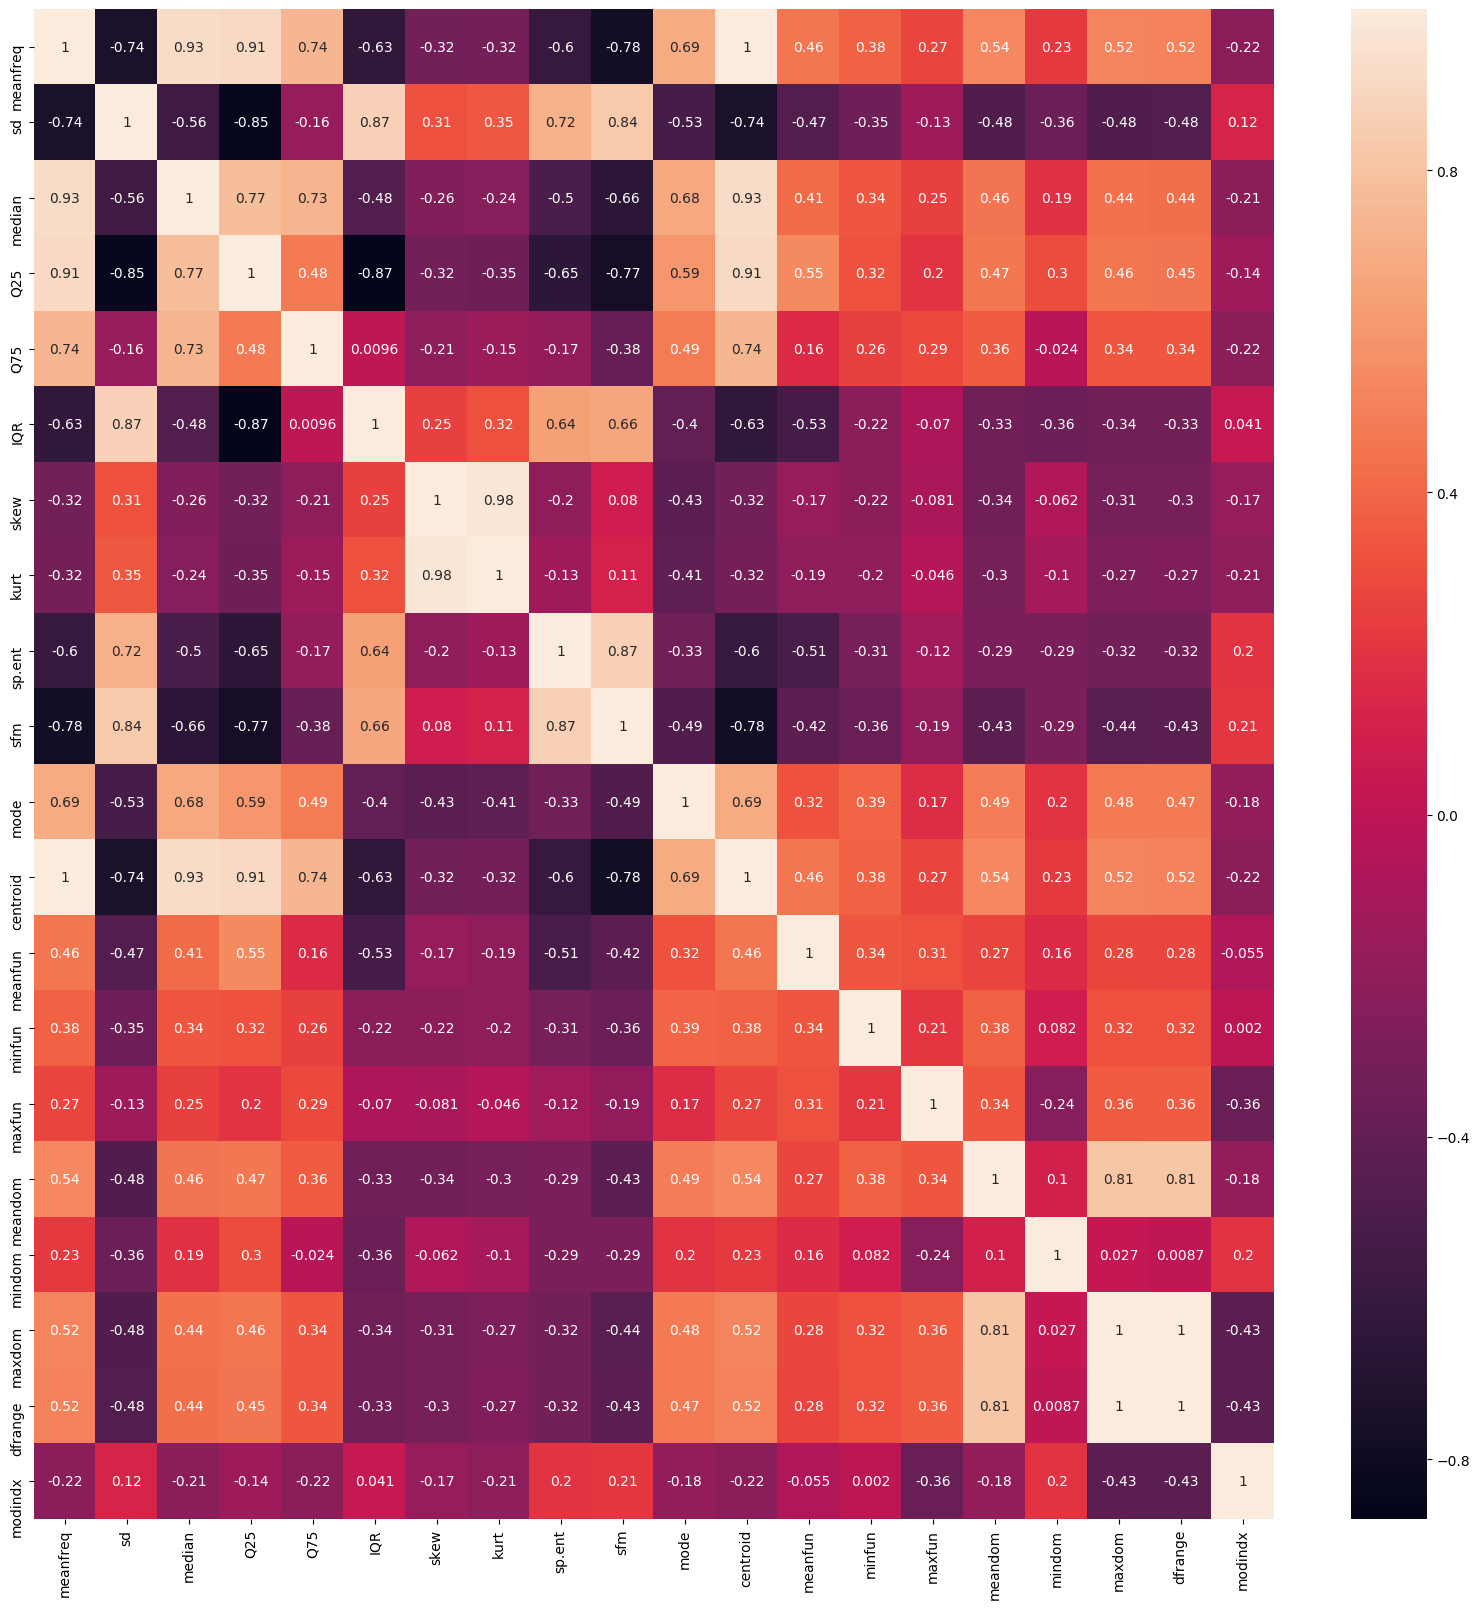

In [8]:
plt.figure(figsize=(20,20),dpi = 100)
sns.heatmap(dane.corr(),annot = dane.corr())

## Wnioski


## Przygotowanie danych do analizy 


In [65]:
dane= pd.read_csv('voice.csv')
dane=dane.replace(0, dane.mean())

4.9946296923088305


W celu przygotowania danych do analizy brakujące dane zostały zastąpione średnią wartością atrybutu. 

## GRUPOWANIE TEST

grupa    0     1
label           
female  21  1563
male    63  1521


Text(0.5, 1, 'macierz pomyłek')

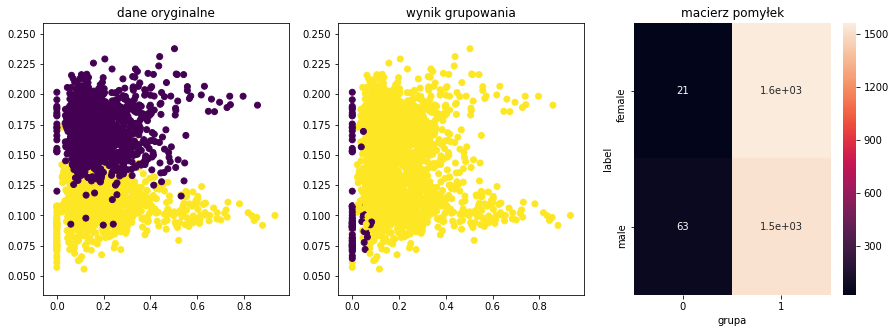

In [12]:
ile_grup = 2
df_org = pd.read_csv('voice.csv')
df = df_org.drop(columns = ['label'])

model = AgglomerativeClustering(linkage='complete', affinity='euclidean', n_clusters=ile_grup)
model.fit(df)

klasa = df_org['label'].astype('category').cat.codes
grupa = model.labels_

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter( x=df_org['modindx'], y=df_org['meanfun'], c=klasa)
plt.title('dane oryginalne')
plt.subplot(1,3,2)
df['grupa']=  model.labels_
plt.scatter( x=df['modindx'], y=df['meanfun'], c=grupa)
plt.title('wynik grupowania')
plt.subplot(1,3,3)
pomylki = pd.crosstab(df_org['label'],df['grupa'])
print(pomylki)
sns.heatmap(pomylki,annot = pomylki)
plt.title('macierz pomyłek')

## k śriednich 

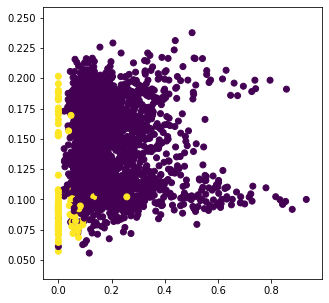

In [15]:
k = 2
df_org = pd.read_csv('voice.csv')
df = df_org.drop(columns = ['label'])

kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df)
etykiety_klastrow = kmeans.fit_predict(df)
plt.figure(figsize=(5,5))
plt.scatter(df.modindx, df.meanfun, marker='o', c=etykiety_klastrow)

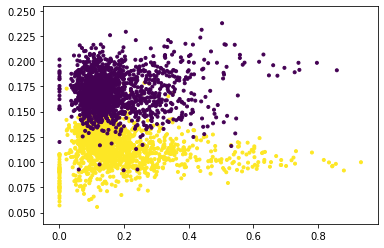

In [18]:
df = pd.read_csv('voice.csv')
plt.scatter(df.loc[:, 'modindx'], df.loc[:, 'meanfun'], c=df["label"].astype('category').cat.codes, marker = '.')
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
nbrs.fit(df[['modindx','meanfun']])
distances, indices = nbrs.kneighbors(df[['modindx','meanfun']])

In [6]:
def podziel(df,proporcja):
    # dzieli macierz (ramkę) danych na zbiór uczacy i testowy
    # df - ramka danych; proporcja - proporcja podzialu (0-1)
    # zwraca słownik z kluczami:
    # opis_ucz/opis_test - macierz atrybutów opisujących zbioru uczącego/testowego
    # dec_ucz/dec_test - wektor wartosci atrybutu decyzyjnego zbioru uczącego/testowego
    # uwaga: atrybut opisujący jest zawsze na końcu (ostatnia kolumna ramki)
    opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1].astype('category').cat.codes, test_size=proporcja)#, random_state=0)
    return {"opis_ucz":opis_ucz, "opis_test":opis_test, "dec_ucz":dec_ucz, "dec_test":dec_test}


In [7]:
def weryfikuj(model,dane,atryb):
    # wyswietla wynik weryfikacji klasyfikatora w postaci macierzy pomyłek
    # dla zbioru uczącego i testowego
    # model - model klasyfikatora
    # dane - dane (słownik zwracany przez funkcje podziel)
    # atryb - lista atrybutów uwzględnianych w weryfikacji
    model.fit(dane["opis_ucz"].iloc[:,atryb], dane["dec_ucz"])
    wynik_ucz = model.predict(dane["opis_ucz"].iloc[:,atryb])
    wynik_test = model.predict(dane["opis_test"].iloc[:,atryb])
    print("Macierz pomyłek dla zbioru uczącego")
    print(pd.crosstab(dane["dec_ucz"],wynik_ucz)) 
    print("Macierz pomyłek dla zbioru testowego")
    print(pd.crosstab(dane["dec_test"],wynik_test)) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
meanfreq    3168 non-null float64
sd          3168 non-null float64
median      3168 non-null float64
Q25         3168 non-null float64
Q75         3168 non-null float64
IQR         3168 non-null float64
skew        3168 non-null float64
kurt        3168 non-null float64
sp.ent      3168 non-null float64
sfm         3168 non-null float64
mode        3168 non-null float64
centroid    3168 non-null float64
meanfun     3168 non-null float64
minfun      3168 non-null float64
maxfun      3168 non-null float64
meandom     3168 non-null float64
mindom      3168 non-null float64
maxdom      3168 non-null float64
dfrange     3168 non-null float64
modindx     3168 non-null float64
label       3168 non-null object
dtypes: float64(20), object(1)
memory usage: 519.8+ KB
None
Macierz pomyłek dla zbioru uczącego
col_0     0     1
row_0            
0      1118     0
1         0  1099
Macierz pomy

In [8]:
def granice(model,dane,atr_x, atr_y,tytul,kontur = 1):
    # wyswietla granice decyzyjne
    # model - model klasyfikatora
    # dane - dane (słownik zwracany przez funkcje podziel)
    # atr_x/atr_y - artybut wyswietlany na osi x/y
    # tytul - wyswietlany tytul wykresu
    # kontur - par. opcjonalny (=0 -> brak konturu)
    if (kontur == 1):    
        model.fit(dane["opis_ucz"].iloc[:,[atr_x,atr_y]], dane["dec_ucz"])
        x_min = min(dane["opis_ucz"].iloc[:, atr_x].min(),dane["opis_test"].iloc[:, atr_x].min())
        x_max = max(dane["opis_ucz"].iloc[:, atr_x].max(),dane["opis_test"].iloc[:, atr_x].max())
        y_min = min(dane["opis_ucz"].iloc[:, atr_y].min(),dane["opis_test"].iloc[:, atr_y].min())
        y_max = max(dane["opis_ucz"].iloc[:, atr_y].max(),dane["opis_test"].iloc[:, atr_y].max())
        rozst_x = x_max - x_min
        rozst_y = y_max - y_min
        x_min = x_min - 0.1*rozst_x
        x_max = x_max + 0.1*rozst_x
        y_min = y_min - 0.1*rozst_y
        y_max = y_max + 0.1*rozst_y       
        xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/150),
                     np.arange(y_min, y_max, (y_max-y_min)/150))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
    plt.figure(dpi = 100)
    plt.title(tytul)
    if (kontur == 1):
        plt.contourf(xx, yy, Z, levels = 4, alpha=0.2)
    plt.scatter(dane["opis_ucz"].iloc[:, atr_x], dane["opis_ucz"].iloc[:, atr_y], c=dane["dec_ucz"], marker = '.')
    plt.scatter(dane["opis_test"].iloc[:, atr_x], dane["opis_test"].iloc[:, atr_y], c=dane["dec_test"], marker = 'x')

Macierz pomyłek dla zbioru uczącego
col_0     0     1
row_0            
0      1101     0
1         0  1116
Macierz pomyłek dla zbioru testowego
col_0    0    1
row_0          
0      445   38
1       26  442


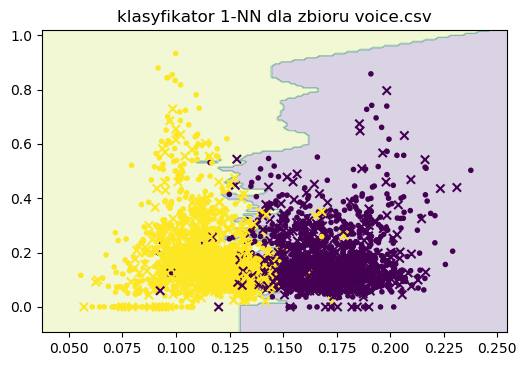

In [147]:
nazwa_pliku = 'voice.csv'
# wczytanie badanego zbioru danych
df = pd.read_csv(nazwa_pliku)
# podział zbioru danych
d = podziel(df,0.3)
# zdefiniowanie modelu klasyfikatora
model = KNeighborsClassifier(n_neighbors=1)
# wybór atrybutów
ax, ay = 12,19
# granice dycyzyjne
granice(model,d,ax,ay,"klasyfikator 1-NN dla zbioru " + nazwa_pliku)
# weryfikacja
weryfikuj(model,d,[ax,ay])

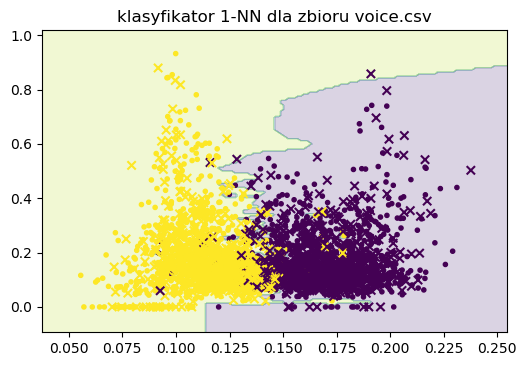

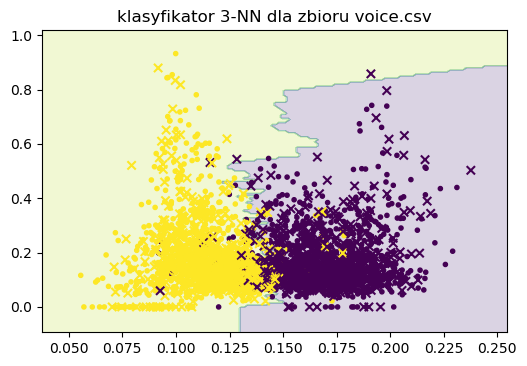

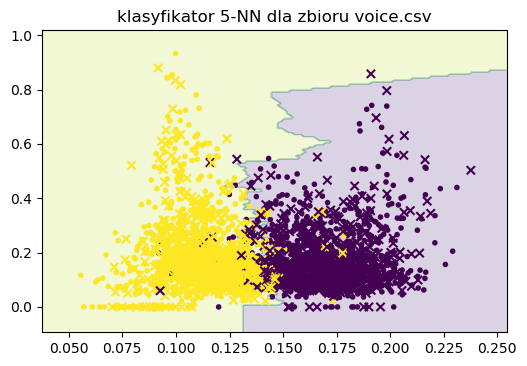

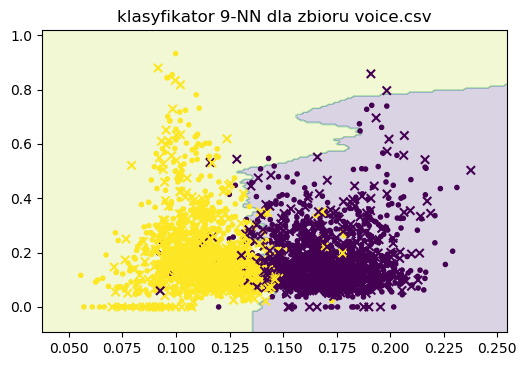

In [148]:
nazwa_pliku = 'voice.csv'
df = pd.read_csv(nazwa_pliku)
d = podziel(df,0.3)
for k in [1,3,5,9]:
    model_knn = KNeighborsClassifier(n_neighbors=k)
    granice(model_knn,d,12,19,"klasyfikator " + str(k)+ "-NN dla zbioru " + nazwa_pliku)

## Naiwny klasyfikator Bayesa

Macierz pomyłek dla zbioru uczącego
col_0     0     1
row_0            
0      1034    67
1        42  1074
Macierz pomyłek dla zbioru testowego
col_0    0    1
row_0          
0      457   26
1       22  446


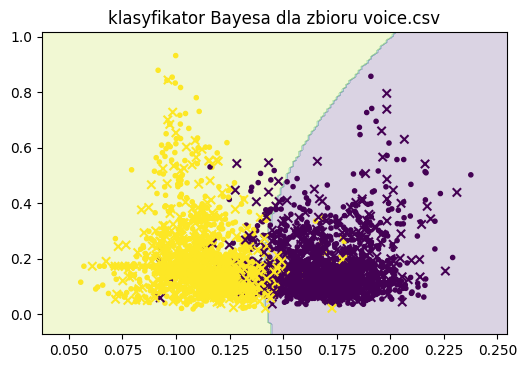

In [9]:
nazwa_pliku = 'voice.csv'
# wczytanie badanego zbioru danych
df = pd.read_csv(nazwa_pliku)
df=df.replace(0, df.mean())
# podział zbioru danych
d = podziel(df,0.3)
# zdefiniowanie modelu klasyfikatora
model = GaussianNB()
# granice dycyzyjne
granice(model,d,12,19,"klasyfikator Bayesa dla zbioru " + nazwa_pliku)
# weryfikacja
weryfikuj(model,d,[12,19])